In [1]:
import register_data
import predict
import detectron2
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



### 1. Resize and Format all annotations files(.json)

In [7]:
json_directory = "./discharge_curve_json/"
img_height = 400
img_width = 600
dataset_dict, imgs, polygon_list = register_data.json_to_dict(json_directory, img_height, img_width)

### 2. Visualize Resized Images and Masks

/mnt/c/users/daniu/desktop/DataYoink/examples/register_data.py:127: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


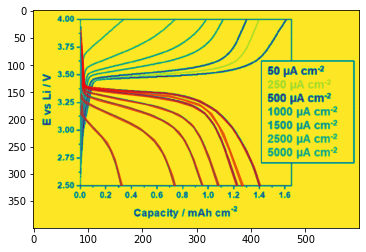

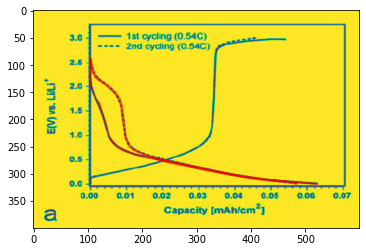

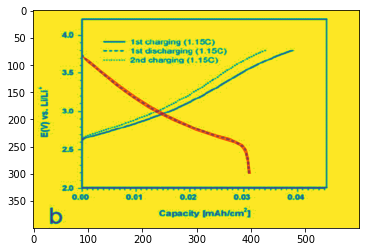

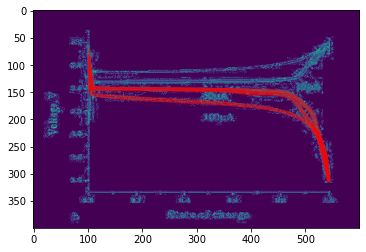

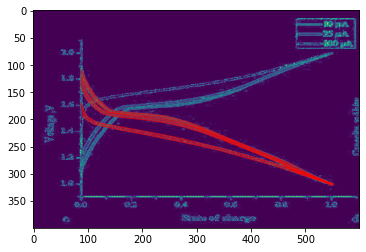

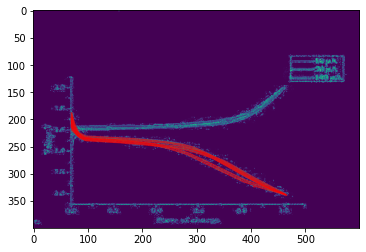

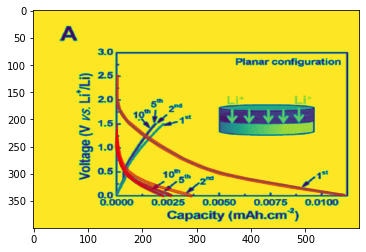

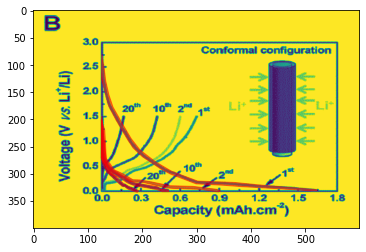

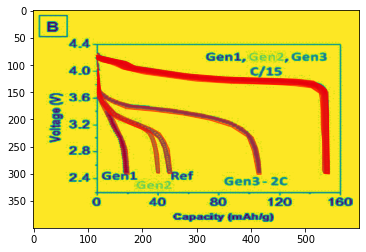

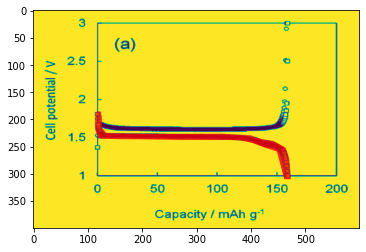

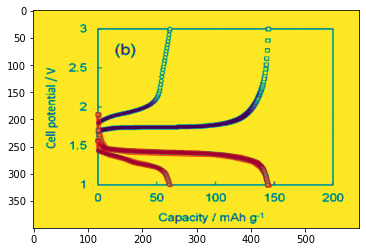

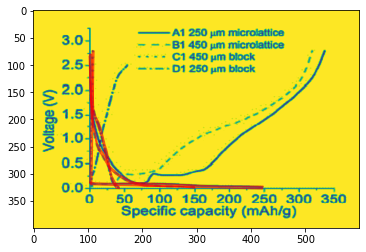

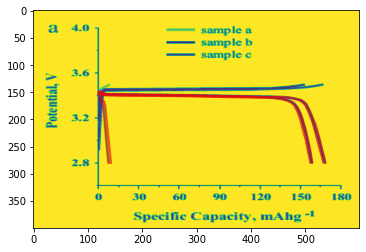

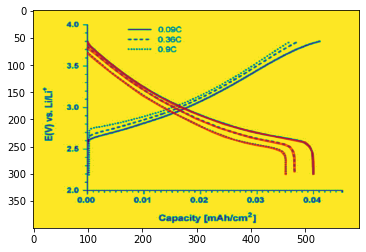

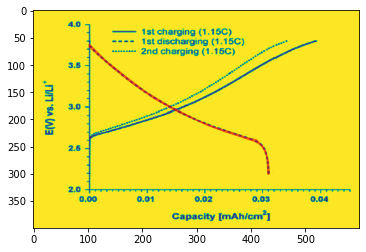

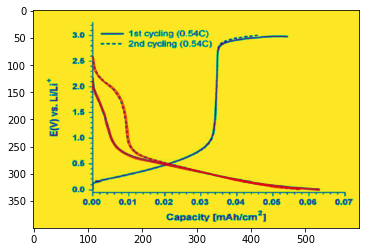

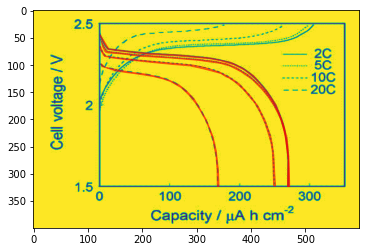

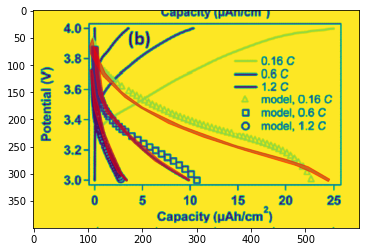

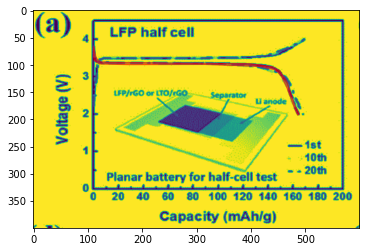

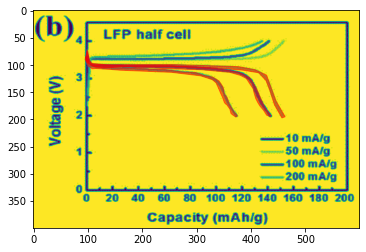

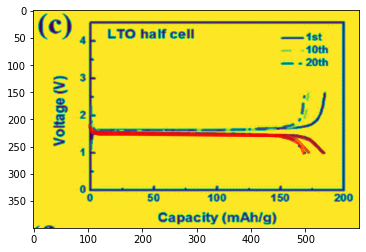

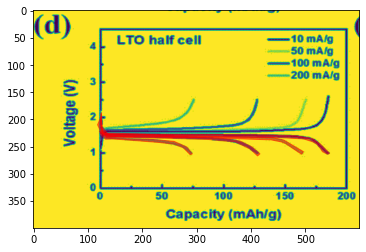

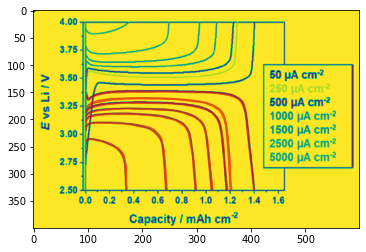

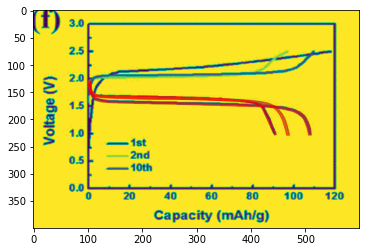

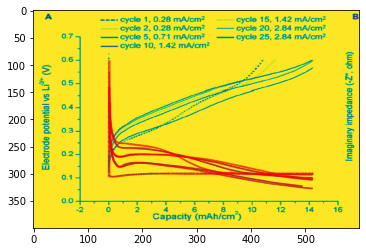

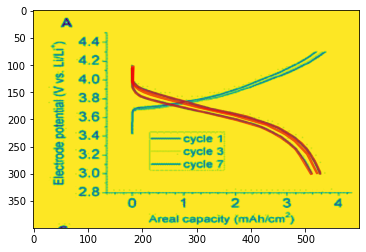

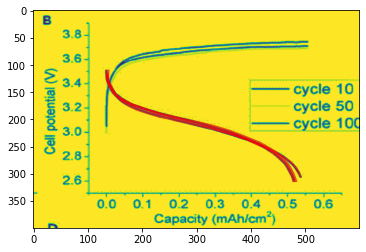

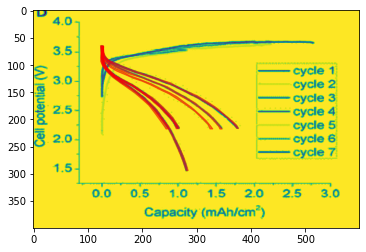

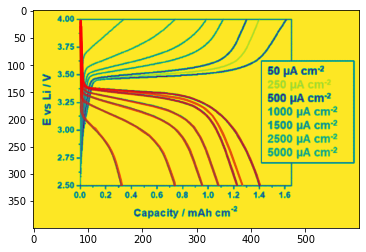

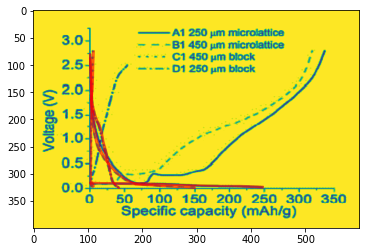

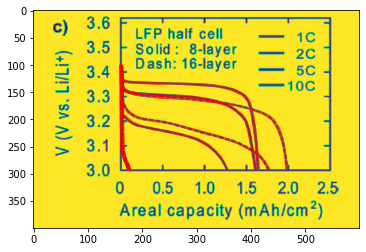

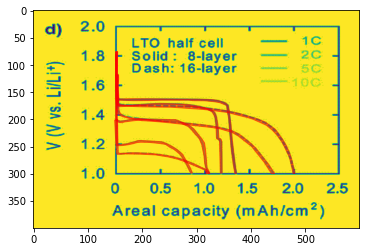

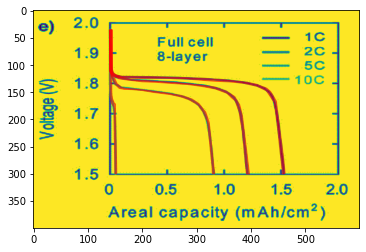

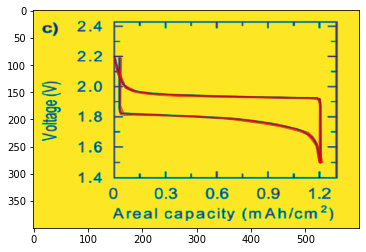

In [9]:
register_data.show_img_and_mask(imgs,polygon_list)

### 3. Register Dataset to Detectron2 as "discharge_curve"

In [10]:
DatasetCatalog.register("discharge_curve", lambda: dictionary_fuction_for_detectron2("./discharge_curve_json/",400,600))
MetadataCatalog.get("discharge_curve").set(thing_classes=["discharge_curve"])

namespace(name='discharge_curve', thing_classes=['discharge_curve'])

### 4. Train the Neural Network with the Registered Dataset

In [ ]:
cfg = get_cfg()
# Set outpu directory
cfg.OUTPUT_DIR = "./output"
# Use pretrained RCNN
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# Use our training dataset
cfg.DATASETS.TRAIN = ("discharge_curve",)
cfg.DATASETS.TEST = ()
# number of parallel data loading workers
cfg.DATALOADER.NUM_WORKERS = 2
# use pretrained weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
# in 1 iteration the model sees 2 images
cfg.SOLVER.IMS_PER_BATCH = 2
# set learning rate
cfg.SOLVER.BASE_LR = 0.00025
# number of iteration
cfg.SOLVER.MAX_ITER = 10
# number of proposals to sample for training
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 1
# number of classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

#### Extra settings for cpu only scenario
cfg.MODEL.DEVICE = "cpu"
cfg.MODEL.RPN.BBOX_REG_LOSS_TYPE = "smooth_l1"
cfg.MODEL.RPN.BBOX_REG_LOSS_WEIGHT = 1.0
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_TYPE = "smooth_l1"
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_WEIGHT = 1.0

In [ ]:
# Train the Neural Network
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

### 5. Save the Trained Neural Network Configuration as .pkl file

In [ ]:
# Update weights in the configuration
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5#0.63   # set the testing threshold for this model
# Save the neural network as .pkl file
filename = './output/config.pkl'
with open(filename, 'wb') as file:
     pickle.dump(cfg, file)